In [2]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GINConv, GATConv, global_mean_pool
import itertools
import numpy as np
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [ ]:
sp500 = yf.download("^GSPC", start="2020-01-01")
nasdaq = yf.download("^IXIC", start="2020-01-01")
dxy = yf.download("DX-Y.NYB", start="2020-01-01")
gold = yf.download("GC=F", start="2020-01-01")
silver = yf.download("SI=F", start="2020-01-01")
oil = yf.download("CL=F", start="2020-01-01")
bond_10y = yf.download("^TNX", start="2020-01-01")
bond_2y = yf.download("^IRX", start="2020-01-01")
btc = yf.download("BTC-USD", start="2020-01-01")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

YF.download() has changed argument auto_adjust default to True



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
df = btc[["Close"]].rename(columns={"Close": "BTC_Close"})
df = df.join(
    [
        sp500[["Close"]].rename(columns={"Close": "SP500"}),
        nasdaq[["Close"]].rename(columns={"Close": "NASDAQ"}),
        dxy[["Close"]].rename(columns={"Close": "DXY"}),
        gold[["Close"]].rename(columns={"Close": "Gold"}),
        silver[["Close"]].rename(columns={"Close": "Silver"}),
        oil[["Close"]].rename(columns={"Close": "Oil"}),
        bond_10y[["Close"]].rename(columns={"Close": "Bond_10Y"}),
        bond_2y[["Close"]].rename(columns={"Close": "Bond_2Y"}),
    ],
    how="left",
)

In [ ]:
df = df.dropna()
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

In [ ]:
feature_cols = [
    "SP500",
    "NASDAQ",
    "DXY",
    "Gold",
    "Silver",
    "Oil",
    "Bond_10Y",
    "Bond_2Y",
    "BTC_Close",
]
scaler = StandardScaler()
df_scaled[feature_cols] = scaler.fit_transform(df_scaled[feature_cols])
X_scaled = df_scaled[feature_cols].values
num_nodes = len(feature_cols)
edges = list(itertools.combinations(range(num_nodes), 2))
edges = torch.tensor(edges, dtype=torch.long).T

In [ ]:
class DeepMarketGIN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DeepMarketGIN, self).__init__()
        self.conv1 = GINConv(
            torch.nn.Sequential(
                torch.nn.Linear(input_dim, hidden_dim),
                torch.nn.ReLU(),
                torch.nn.Linear(hidden_dim, hidden_dim),
                torch.nn.ReLU(),
            )
        )
        self.conv2 = GINConv(
            torch.nn.Sequential(
                torch.nn.Linear(hidden_dim, hidden_dim),
                torch.nn.ReLU(),
                torch.nn.Linear(hidden_dim, hidden_dim),
                torch.nn.ReLU(),
            )
        )
        self.conv3 = GINConv(
            torch.nn.Sequential(
                torch.nn.Linear(hidden_dim, hidden_dim),
                torch.nn.ReLU(),
                torch.nn.Linear(hidden_dim, hidden_dim),
                torch.nn.ReLU(),
            )
        )
        self.conv4 = GINConv(
            torch.nn.Sequential(
                torch.nn.Linear(hidden_dim, hidden_dim),
                torch.nn.ReLU(),
                torch.nn.Linear(hidden_dim, output_dim),
            )
        )

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = self.conv4(x, edge_index)
        x = global_mean_pool(x, data.batch)
        return x


class DeepMarketGAT(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_gnn_layers=4, heads=8):
        super(DeepMarketGAT, self).__init__()
        self.gnn_layers = nn.ModuleList()
        self.gnn_layers.append(GATConv(input_dim, hidden_dim, heads=heads, concat=True))
        for _ in range(num_gnn_layers - 2):
            self.gnn_layers.append(GATConv(hidden_dim * heads, hidden_dim, heads=heads, concat=True))
        self.gnn_layers.append(GATConv(hidden_dim * heads, output_dim, heads=1, concat=False))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        for conv in self.gnn_layers:
            x = F.elu(conv(x, edge_index))
        x = global_mean_pool(x, data.batch)
        return x


# Optimized Transformer: Deeper with LayerNorm & Extra Feedforward Block
class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, num_heads, num_layers, hidden_dim, dropout):
        super(TimeSeriesTransformer, self).__init__()

        self.encoder_layers = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim,
            dropout=dropout,
            batch_first=True,
            norm_first=True,
        )
        self.transformer_encoder = nn.TransformerEncoder(
            self.encoder_layers, num_layers=num_layers
        )

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = self.transformer_encoder(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


class GNNTransformer(nn.Module):
    def __init__(
        self, input_dim, hidden_dim, gnn_output_dim, num_gnn_layers,
        num_heads, num_transformer_layers, ffn_hidden_dim, dropout
    ):
        super(GNNTransformer, self).__init__()
        self.gnn = DeepMarketGAT(input_dim, hidden_dim, gnn_output_dim, num_gnn_layers, heads=num_heads)
        self.time_series_proj = nn.Sequential(
            nn.LayerNorm(input_dim),
            nn.Linear(input_dim, gnn_output_dim),
            nn.ReLU(),
        )
        self.gnn_proj = nn.Sequential(
            nn.LayerNorm(gnn_output_dim),
            nn.Linear(gnn_output_dim, gnn_output_dim),
            nn.ReLU(),
        )
        self.cross_attention = nn.MultiheadAttention(embed_dim=gnn_output_dim, num_heads=num_heads, batch_first=True)
        self.transformer = TimeSeriesTransformer(
            gnn_output_dim, num_heads, num_transformer_layers, ffn_hidden_dim, dropout
        )

    def forward(self, data, time_series):
        gnn_output = self.gnn(data)
        gnn_output = gnn_output.unsqueeze(0).expand(time_series.shape[0], -1, -1)
        gnn_output = gnn_output.mean(dim=1, keepdim=True).expand(-1, time_series.shape[1], -1)

        time_series = self.time_series_proj(time_series)
        time_series = self.gnn_proj(time_series)

        combined_input, _ = self.cross_attention(time_series, gnn_output, gnn_output)
        return self.transformer(combined_input)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_tensor = torch.tensor(df_scaled[feature_cols].values, dtype=torch.float32, device=device)
Y_tensor = torch.tensor(df_scaled["BTC_Close"].values, dtype=torch.float32, device=device)

# Split into train/test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_tensor, Y_tensor, test_size=0.2, random_state=42, shuffle=True)

# Create graph data
graph_data = Data(
    x=X_tensor[:num_nodes],
    edge_index=edges.to(device),
    num_nodes=num_nodes
).to(device)

# Reshape into batch format
X_train_tensor, Y_train_tensor = X_train.unsqueeze(0), Y_train.unsqueeze(0)
X_test_tensor, Y_test_tensor = X_test.unsqueeze(0), Y_test.unsqueeze(0)

In [ ]:
hyperparams = {
    "hidden_dim": 256,
    "gnn_output_dim": 64,
    "num_heads": 8,
    "num_gnn_layers": 4,
    "num_transformer_layers": 6,
    "ffn_hidden_dim": 512,
    "dropout": 0.3,
    "learning_rate": 0.0005,
    "weight_decay": 5e-5,
    "max_epochs": 3000,
    "patience": 100,
    "grad_clip": 3.0,
}

final_model = GNNTransformer(
    input_dim=len(feature_cols),
    hidden_dim=hyperparams["hidden_dim"],
    gnn_output_dim=hyperparams["gnn_output_dim"],
    num_heads=hyperparams["num_heads"],
    num_gnn_layers=hyperparams["num_gnn_layers"],
    num_transformer_layers=hyperparams["num_transformer_layers"],
    ffn_hidden_dim=hyperparams["ffn_hidden_dim"],
    dropout=hyperparams["dropout"],
).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(final_model.parameters(), lr=hyperparams["learning_rate"], weight_decay=hyperparams["weight_decay"])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=hyperparams["patience"], verbose=True)

best_loss = float("inf")
early_stop_counter = 0
best_model_path = "best_gnn_transformer.pth"

print("🚀 Training Started...")

for epoch in range(hyperparams["max_epochs"]):
    final_model.train()
    optimizer.zero_grad()
    predictions = final_model(graph_data, X_train_tensor)
    loss = criterion(predictions, Y_train_tensor)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(final_model.parameters(), hyperparams["grad_clip"])
    optimizer.step()
    scheduler.step(loss)

    if loss.item() < best_loss:
        best_loss = loss.item()
        early_stop_counter = 0
        torch.save(final_model.state_dict(), best_model_path)
    else:
        early_stop_counter += 1
    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{hyperparams['max_epochs']} - Loss: {loss.item():.6f}")
    if early_stop_counter >= hyperparams["patience"]:
        print(f"⏹ Early stopping at epoch {epoch}. Best Loss: {best_loss:.6f}")
        break

print("🎉 Training Complete!")

final_model.load_state_dict(torch.load(best_model_path))
final_model.eval()

with torch.no_grad():
    test_predictions = final_model(graph_data, X_test.unsqueeze(0)).cpu().detach().numpy()

test_loss = mean_squared_error(Y_test.cpu().numpy(), test_predictions.flatten())
print(f"📊 Final Test Set MSE: {test_loss:.5f}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


🚀 Training Started...
Epoch 0/3000 - Loss: 1.057783
Epoch 100/3000 - Loss: 1.019639
⏹ Early stopping at epoch 132. Best Loss: 1.010260
🎉 Training Complete!
📊 Final Test Set MSE: 0.95682


<ipython-input-24-3f58d45a2715>:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_model.load_state_dict(torch.load(best_model_path))


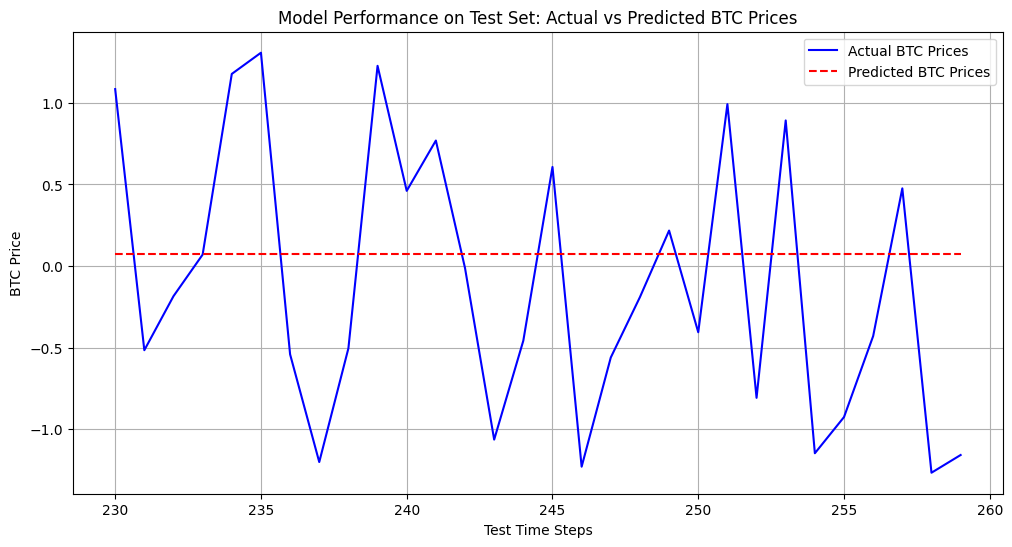

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

with torch.no_grad():
    test_predictions = final_model(graph_data, X_test.unsqueeze(0)).squeeze().cpu().numpy()  # 预测的 BTC 价格

test_btc_prices = Y_test.cpu().numpy()
test_days = np.arange(len(test_btc_prices))

plt.figure(figsize=(12, 6))
plt.plot(test_days[-30:], test_btc_prices[-30:], label="Actual BTC Prices", color="blue")
plt.plot(test_days[-30:], test_predictions[-30:], label="Predicted BTC Prices", color="red", linestyle="dashed")

plt.xlabel("Test Time Steps")
plt.ylabel("BTC Price")
plt.title("Model Performance on Test Set: Actual vs Predicted BTC Prices")
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
# Define Nested Cross-Validation parameters
OUTER_FOLDS = 3  # Outer loop: Splitting training & test sets
INNER_FOLDS = 5  # Inner loop: K-Fold cross-validation for hyperparameter tuning

# Define hyperparameter search space
HYPERPARAM_GRID = [
    {"hidden_dim": 32, "num_heads": 4, "num_layers": 3, "dropout": 0.1},
    {"hidden_dim": 64, "num_heads": 8, "num_layers": 4, "dropout": 0.2},
    {"hidden_dim": 128, "num_heads": 8, "num_layers": 6, "dropout": 0.3},
]

# Load dataset
X = df_scaled[feature_cols].values
Y = df_scaled["BTC_Close"].values

# Convert dataset to tensor
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

# Nested Cross-Validation
outer_scores = []
best_hyperparams = []

for outer_fold, (train_idx, test_idx) in enumerate(
    KFold(n_splits=OUTER_FOLDS, shuffle=True, random_state=42).split(X)
):
    print(
        f"\n🔹 Outer Fold {outer_fold + 1}/{OUTER_FOLDS} - Train Set: {len(train_idx)}, Test Set: {len(test_idx)}"
    )

    # Split dataset into training & test sets
    X_train, X_test = X_tensor[train_idx], X_tensor[test_idx]
    Y_train, Y_test = Y_tensor[train_idx], Y_tensor[test_idx]

    best_inner_score = float("inf")
    best_params = None

    for hyperparams in HYPERPARAM_GRID:
        inner_scores = []

        # Inner loop: K-Fold cross-validation for hyperparameter selection
        for inner_fold, (train_inner_idx, val_idx) in enumerate(
            KFold(n_splits=INNER_FOLDS, shuffle=True).split(X_train)
        ):
            X_train_inner, X_val = X_train[train_inner_idx], X_train[val_idx]
            Y_train_inner, Y_val = Y_train[train_inner_idx], Y_train[val_idx]

            # Initialize model with current hyperparameters
            model = GNNTransformer(
                input_dim=len(feature_cols),
                hidden_dim=hyperparams["hidden_dim"],
                gnn_output_dim=32,
                num_heads=hyperparams["num_heads"],
                num_layers=hyperparams["num_layers"],
                dropout=hyperparams["dropout"],
            )

            criterion = nn.MSELoss()
            optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)

            graph_data = Data(
                x=torch.tensor(
                    X_scaled[:num_nodes], dtype=torch.float32
                ),
                edge_index=edges,
                num_nodes=num_nodes,
            )

            # Train model
            for epoch in range(30):
                optimizer.zero_grad()
                predictions = model(graph_data, X_train_inner.unsqueeze(0))
                loss = criterion(predictions, Y_train_inner.unsqueeze(0))
                loss.backward()
                optimizer.step()

            # Evaluate model on validation set
            val_predictions = model(graph_data, X_val.unsqueeze(0)).detach().numpy()
            val_loss = mean_squared_error(Y_val.numpy(), val_predictions.flatten())
            inner_scores.append(val_loss)

        # Compute the average inner validation score
        avg_inner_score = np.mean(inner_scores)
        print(
            f"✅ Hyperparameters {hyperparams} - Average Inner CV MSE: {avg_inner_score:.5f}"
        )

        # Update the best hyperparameter set
        if avg_inner_score < best_inner_score:
            best_inner_score = avg_inner_score
            best_params = hyperparams

    print(f"🔥 Best Hyperparameters for Outer Fold {outer_fold + 1}: {best_params}")

    # Train final model with the best hyperparameters
    final_model = GNNTransformer(
        input_dim=len(feature_cols),
        hidden_dim=best_params["hidden_dim"],
        gnn_output_dim=32,
        num_heads=best_params["num_heads"],
        num_layers=best_params["num_layers"],
        dropout=best_params["dropout"],
    )

    criterion = nn.MSELoss()
    optimizer = optim.AdamW(final_model.parameters(), lr=0.0005, weight_decay=1e-4)

    # Train on the entire training set
    for epoch in range(50000):
        optimizer.zero_grad()
        predictions = final_model(graph_data, X_train.unsqueeze(0))
        loss = criterion(predictions, Y_train.unsqueeze(0))
        loss.backward()
        optimizer.step()

    # Evaluate final model on test set
    test_predictions = final_model(graph_data, X_test.unsqueeze(0)).detach().numpy()
    test_loss = mean_squared_error(Y_test.numpy(), test_predictions.flatten())
    print(f"📊 Outer Fold {outer_fold + 1} Test Set MSE: {test_loss:.5f}")

    # Save results
    outer_scores.append(test_loss)
    best_hyperparams.append(best_params)

# Final evaluation
print("\n✅ Nested Cross-Validation Results")
print(
    f"📌 Average Test Set MSE: {np.mean(outer_scores):.5f} ± {np.std(outer_scores):.5f}"
)
print(f"📌 Best Hyperparameter Set: {best_hyperparams}")